In [2]:
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.applications import VGG16, VGG19, Xception, ResNet50, InceptionResNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [4]:
# Input
#DATA_DIR = Path('/scratch/imb/Andrew/HEMnet')
DATA_DIR = Path('/QRISdata/Q1139/ST_Projects/HEMnet/')
#TRAIN_DIR = DATA_DIR.joinpath('train_dataset_10x_13_12_19_strict/tiles_10x')
#VAL_DIR = DATA_DIR.joinpath('gold_standards/1794_T/tiles_10x')
TRAIN_DIR = DATA_DIR.joinpath('Training_Datasets/train_dataset_10x_27_05_20_strict_vahadane2/tiles_10x')
VAL_DIR = DATA_DIR.joinpath('Validation_Datasets/val_dataset_10x_24_06_20_vahadane/tiles_10x')

# Output

In [5]:
TRAIN_CANCER_DIR = TRAIN_DIR.joinpath('cancer')
TRAIN_NON_CANCER_DIR = TRAIN_DIR.joinpath('non-cancer')
VAL_CANCER_DIR = VAL_DIR.joinpath('cancer')
VAL_NON_CANCER_DIR = VAL_DIR.joinpath('non-cancer')

In [17]:
print('Training cancer images: ', len(list(TRAIN_CANCER_DIR.glob('*jpeg'))))
print('Training non-cancer images: ', len(list(TRAIN_NON_CANCER_DIR.glob('*jpeg'))))
print('Validation cancer images: ', len(list(VAL_CANCER_DIR.glob('*jpeg'))))
print('Validation non-cancer images: ', len(list(VAL_NON_CANCER_DIR.glob('*jpeg'))))

Training cancer images:  3602
Training non-cancer images:  5290
Validation cancer images:  2147
Validation non-cancer images:  3666


In [15]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
#     rotation_range = 360,
#     horizontal_flip = True,
     vertical_flip = False)
val_datagen = ImageDataGenerator(rescale=1./255)

In [16]:
#TARGET_SIZE = (299, 299)
#TARGET_SIZE = (150, 150)
TARGET_SIZE = (224, 224)
BATCH_SIZE = 512

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    classes = ['cancer','non-cancer'],
    target_size = TARGET_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'binary')

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    classes = ['cancer','non-cancer'],
    target_size = TARGET_SIZE,
    batch_size = BATCH_SIZE,
    class_mode = 'binary',
    shuffle = False)

Found 8892 images belonging to 2 classes.
Found 5813 images belonging to 2 classes.


In [53]:
num_of_val_samples = 1745

In [54]:
# xception_base = Xception(weights = 'imagenet', include_top = False)
# x = xception_base.output
# features = layers.GlobalMaxPooling2D()(x)

# conv_base = Model(xception_base.input, features)

In [18]:
# conv_base = VGG16(weights = 'imagenet', include_top = False, input_shape = (150, 150, 3))
conv_base = VGG16(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
#conv_base = VGG19(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))

Instructions for updating:
Colocations handled automatically by placer.


In [19]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [20]:
conv_base.input_shape

(None, 224, 224, 3)

In [21]:
conv_base.output_shape

(None, 7, 7, 512)

In [22]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 21,137,729
Trainable params: 21,137,729
Non-trainable params: 0
_________________________________________________________________


In [25]:
print('This is the number of trainable weights '
         'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [26]:
conv_base.trainable = False

In [27]:
print('This is the number of trainable weights '
          'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [28]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

# model.compile(loss='binary_crossentropy',
#               optimizer=optimizers.Adam(),
#               metrics=['acc'])

In [ ]:
history = model.fit_generator(
    train_generator,
    epochs = 30,
    steps_per_epoch = 20,
    validation_data = val_generator)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
18/18 [==============================] - 1622s 90s/step - loss: 0.4011 - acc: 0.8277 - val_loss: 0.7417 - val_acc: 0.6454
Epoch 2/30
18/18 [==============================] - 1598s 89s/step - loss: 0.2117 - acc: 0.9288 - val_loss: 0.7033 - val_acc: 0.6805
Epoch 3/30
18/18 [==============================] - 1598s 89s/step - loss: 0.1751 - acc: 0.9388 - val_loss: 0.6724 - val_acc: 0.7050
Epoch 4/30
18/18 [==============================] - 1616s 90s/step - loss: 0.1529 - acc: 0.9453 - val_loss: 0.6771 - val_acc: 0.7125
Epoch 5/30
18/18 [==============================] - 1610s 89s/step - loss: 0.1347 - acc: 0.9502 - val_loss: 0.6030 - val_acc: 0.7387
Epoch 6/30
18/18 [==============================] - 1604s 89s/step - loss: 0.1244 - acc: 0.9575 - val_loss: 0.6794 - val_acc: 0.7230
Epoch 7/30
18/18 [==============================] - 1608s 89s/step - loss: 0.1157 - acc: 0.9601 - val_loss: 0.6839 - val_acc: 0.7280
Epoch 8/30
18/18 [===

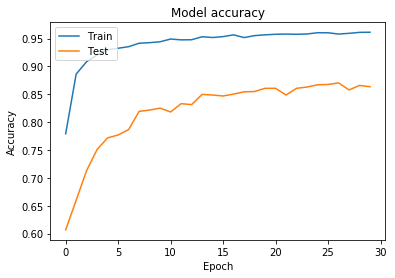

In [65]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

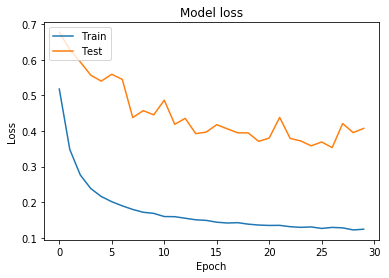

In [66]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

(array([890., 125.,  82.,  53.,  44.,  53.,  47.,  49.,  72., 329.]),
 array([1.14262104e-04, 1.00050038e-01, 1.99985814e-01, 2.99921590e-01,
        3.99857366e-01, 4.99793142e-01, 5.99728918e-01, 6.99664694e-01,
        7.99600470e-01, 8.99536246e-01, 9.99472022e-01]),
 <a list of 10 Patch objects>)

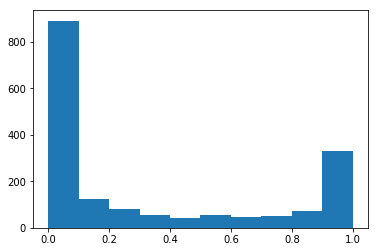

In [67]:
Y_pred = model.predict_generator(val_generator, num_of_val_samples // BATCH_SIZE + 1)
plt.hist(Y_pred)

In [68]:
val_generator.class_indices

{'cancer': 0, 'non-cancer': 1}

In [69]:
y_pred = np.round(Y_pred)

In [70]:
np.unique(y_pred, return_counts = True)

(array([0., 1.], dtype=float32), array([1194,  550]))

In [71]:
cm = confusion_matrix(val_generator.classes, y_pred)
cm

array([[990,  34],
       [204, 516]])

In [72]:
def plot_confusion_matrix(cm, classes=None):
    #Normalise Confusion Matrix by dividing each value by the sum of that row
    cm = cm.astype('float')/cm.sum(axis = 1)[:, np.newaxis]
    print(cm)
    #Make DataFrame from Confusion Matrix and classes
    cm_df = pd.DataFrame(cm, index = classes, columns = classes)
    #Display Confusion Matrix 
    plt.figure(figsize = (4,4), dpi = 300)
    cm_plot = sns.heatmap(cm_df, vmin = 0, vmax = 1, annot = True, fmt = '.2f', cmap = 'Blues', square = True)
    plt.title('Confusion Matrix', fontsize = 12)
    #Display axes labels
    plt.ylabel('True label', fontsize = 12)
    plt.xlabel('Predicted label', fontsize = 12)
    plt.savefig('./age_confusion_matrix_combine.pdf')
    plt.tight_layout()
    return cm_plot

[[0.96679688 0.03320312]
 [0.28333333 0.71666667]]


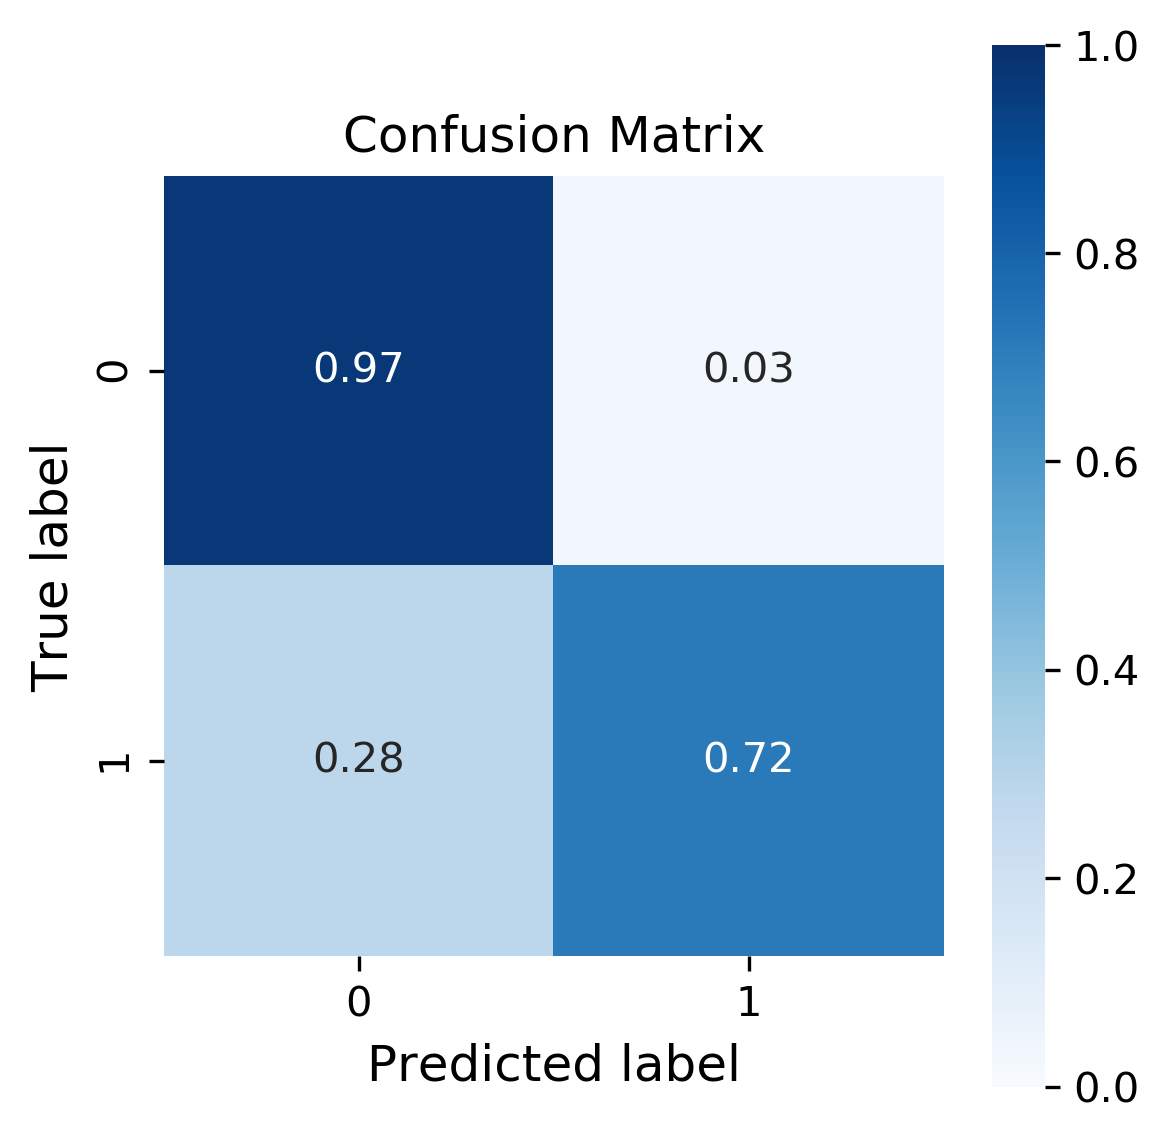

In [73]:
plot_confusion_matrix(cm)